In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchsummary import summary
from tabulate import tabulate

from tqdm import tqdm
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
import os

### Загрузка данных.

In [ ]:
batch_size = 32
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(f'Размер обучающей выборки: {len(train_dataset)}')
print(f'Размер тестовой выборки: {len(test_dataset)}')
print('\nКлассы:')
print(tabulate(
    list(train_dataset.class_to_idx.items()), headers=['Название', 'Индекс'],
    tablefmt='pretty'
))

Размер обучающей выборки: 50000
Размер тестовой выборки: 10000

Классы:
+------------+--------+
|  Название  | Индекс |
+------------+--------+
|  airplane  |   0    |
| automobile |   1    |
|    bird    |   2    |
|    cat     |   3    |
|    deer    |   4    |
|    dog     |   5    |
|    frog    |   6    |
|   horse    |   7    |
|    ship    |   8    |
|   truck    |   9    |
+------------+--------+


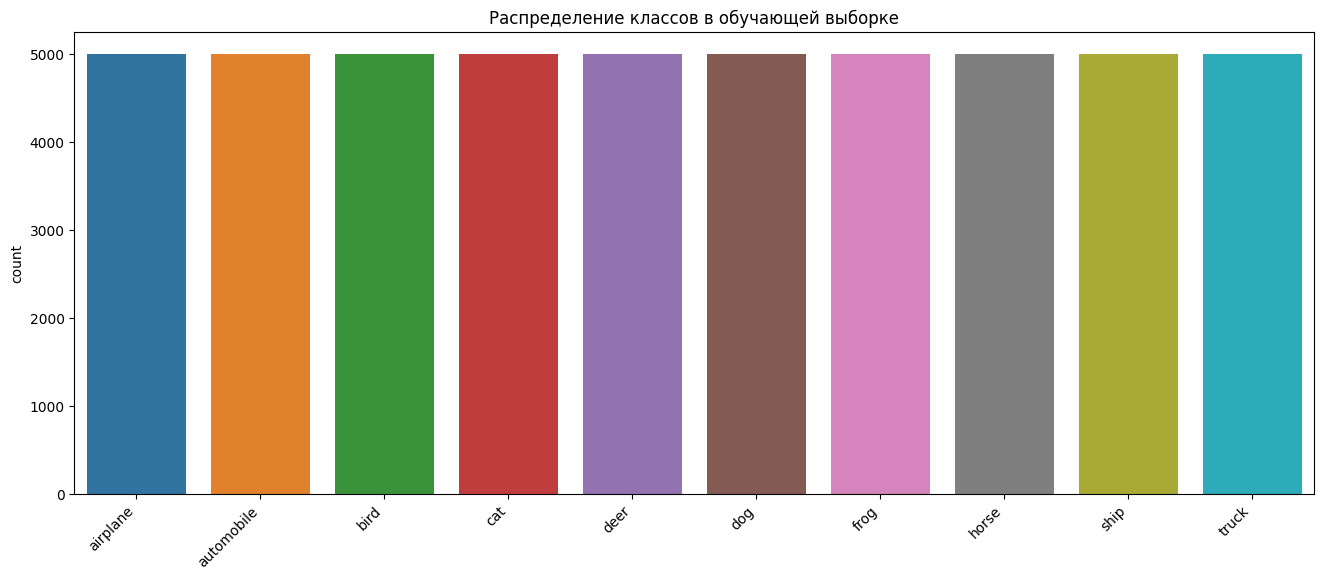

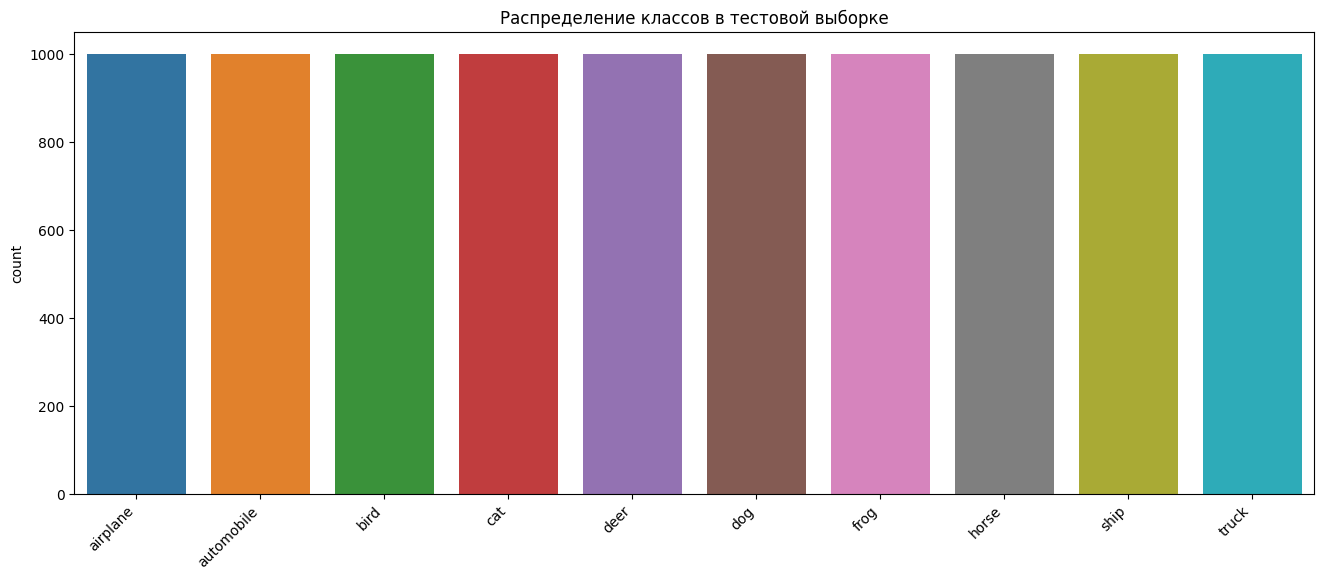

In [ ]:
index_to_label = {v: k for k, v in train_dataset.class_to_idx.items()}

fig, ax = plt.subplots(figsize=(16, 6))

class_labels_train = [index_to_label[idx] for idx in train_dataset.targets]
unique_labels_train = list(index_to_label.values())

sns.countplot(x=class_labels_train, order=unique_labels_train)
plt.title('Распределение классов в обучающей выборке')
plt.xticks(rotation=45, ha='right')
plt.show()

fig, ax = plt.subplots(figsize=(16, 6))

class_labels_test = [index_to_label[idx] for idx in test_dataset.targets]
unique_labels_test = list(index_to_label.values())

sns.countplot(x=class_labels_test, order=unique_labels_test)
plt.title('Распределение классов в тестовой выборке')
plt.xticks(rotation=45, ha='right')
plt.show()


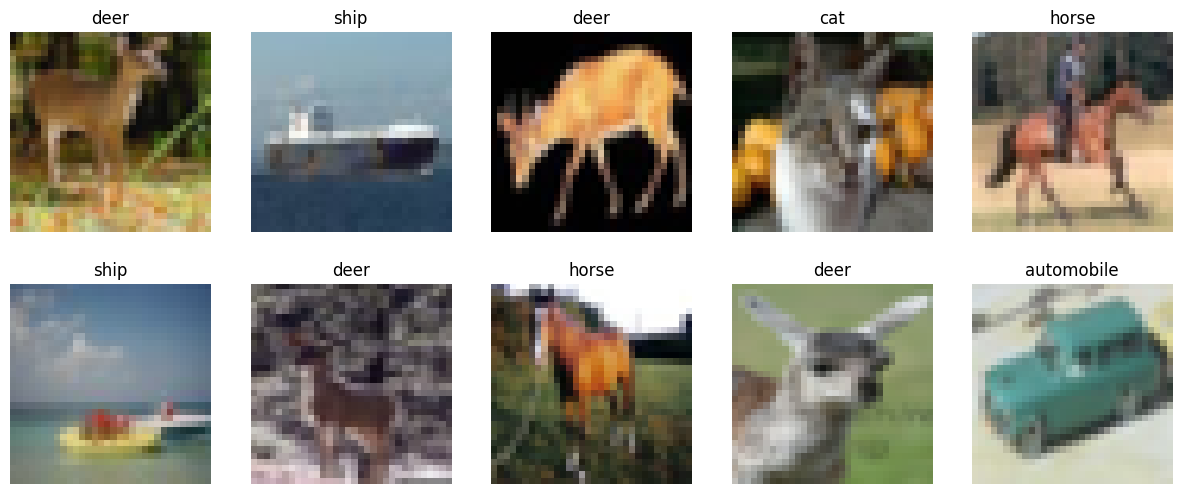

In [ ]:
class_names = test_dataset.classes

def show_images(images, labels):
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.title(class_names[labels[i]])
        plt.imshow(np.clip(np.transpose(images[i], (1, 2, 0)), 0, 1))
        plt.axis('off')
    plt.show()

data_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
data_iter = iter(data_loader)
images, labels = next(data_iter)
show_images(images, labels)

**Вывод**:

1.  Имеем 50 000 в обучающей выборки и 10 000 в тестовой
2.  В каждом классе одинаковое количество классов, дисбаланса не наблюдается
3.  Изображения полностью соответствуют меткам класса

### Построение архитектуры сверточной сети.

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# extra transfrom for the training data, in order to achieve better performance
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # преобразует изображение в тензор PyTorch
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # выполняет нормализацию изображения, применяя линейное масштабирование
                                                                        # к каждому каналу изображения
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'), # выполняет случайное обрезание изображения, позволяя
                                                                              # создать различные варианты одного и того же изображения
    torchvision.transforms.RandomHorizontalFlip(), # выполняет случайное горизонтальное отражение изображения
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Эти методы вместе помогают создать обучающий датасет с разнообразными данными, что способствует лучшей обучаемости нейронной сети и увеличению ее способности к обобщению.

#### SimpleCNN

#### Архитектура модели

1. **Сверточный слой 1 (Convolutional Layer 1)**
   - Входные каналы: 3 (RGB изображение)
   - Выходные каналы: 16
   - Размер ядра свертки: 3x3
   - Заполнение (padding): 1
   - Функция активации: ReLU
   - Операция: Свертка, затем применение функции активации ReLU
   - Пулинг: Максимальное объединение (Max Pooling) с ядром 2x2 и шагом 2

2. **Сверточный слой 2 (Convolutional Layer 2)**
   - Входные каналы: 16
   - Выходные каналы: 32
   - Размер ядра свертки: 3x3
   - Заполнение (padding): 1
   - Функция активации: ReLU
   - Операция: Свертка, затем применение функции активации ReLU
   - Пулинг: Максимальное объединение (Max Pooling) с ядром 2x2 и шагом 2

3. **Полносвязный слой 1 (Fully Connected Layer 1)**
   - Входные признаки: 32x8x8 (результат предыдущих слоев)
   - Выходные признаки: 128
   - Функция активации: ReLU

4. **Полносвязный слой 2 (Fully Connected Layer 2)**
   - Входные признаки: 128
   - Выходные признаки: num_classes (количество классов))


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [ ]:
simple_model = SimpleCNN(num_classes=10)
summary(simple_model, (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 16, 32, 32]             448
              ReLU-2           [32, 16, 32, 32]               0
         MaxPool2d-3           [32, 16, 16, 16]               0
            Conv2d-4           [32, 32, 16, 16]           4,640
              ReLU-5           [32, 32, 16, 16]               0
         MaxPool2d-6             [32, 32, 8, 8]               0
            Linear-7                  [32, 128]         262,272
              ReLU-8                  [32, 128]               0
            Linear-9                   [32, 10]           1,290
Total params: 268,650
Trainable params: 268,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 13.56
Params size (MB): 1.02
Estimated Total Size (MB): 14.96
-----------------------------------------

Имеем по итогу **268 650** обучаемых параметров

---
Создадим класс `CustomEarlyStopping`, который реализует механизм ранней остановки (early stopping) во время обучения нейронной сети. Этот механизм предназначен для контроля процесса обучения и прекращения его, если точность (accuracy) модели на валидационном наборе данных перестает улучшаться.
https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/

In [ ]:
class CustomEarlyStopping():
    """
    Ранняя остановка, чтобы остановить тренировку, когда точность не улучшается после определенной эпохи.
    """
    def __init__(self, patience=5, min_delta=0, path="best_model.pt", path_model="best_model"):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться, когда точность не улучшается
        :param min_delta: минимальная разница между точностью, если улучшений нет, то остановим обучение
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_accuracy = None
        self.early_stop = False
        self.path = path
        self.path_model = path_model

    def __call__(self, test_accuracy, model, optimizer):
        if self.best_accuracy is None:
            self.best_accuracy = test_accuracy
        elif test_accuracy - self.best_accuracy > self.min_delta:
            self.best_accuracy = test_accuracy
            # reset counter if validation accuracy improves
            self.counter = 0
            if os.path.exists(self.path):
                checkpoint = torch.load(self.path)
                if test_accuracy > checkpoint['best_accuracy']:
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_accuracy': test_accuracy,
                    }, self.path)
                    torch.save(model, self.path_model)
            else:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_accuracy': test_accuracy,
                }, self.path)
                torch.save(model, self.path_model)
        elif test_accuracy - self.best_accuracy < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            print(f"Best accuracy {self.best_accuracy}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True


Создадим класс **ClassificationTrainer** обучения моделей.
Он представляет собой обучающий инструмент для нейронных сетей с использованием библиотеки PyTorch. Он обеспечивает обучение модели на тренировочных данных, валидацию на тестовых данных и поддержку механизма ранней остановки.


In [ ]:
class ClassificationTrainer:
    def __init__(self, model: nn.Module, train_loader: DataLoader, test_loader: DataLoader,
                 batch_size: int, learning_rate: float, num_epochs: int, update_frequency: int):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.update_frequency = update_frequency
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.path = str(type(self.model).__name__) + ".pt"
        self.path_model = type(self.model).__name__

        self.losses = {'train': [], 'test': []}
        self.accuracies = {'train': [], 'test': []}

    def train_one_epoch(self):
        self.model.to(self.device).train()
        epoch_loss = 0
        epoch_accuracy = 0
        with tqdm(total=len(self.train_loader)) as pbar:
            for i, batch in enumerate(self.train_loader):
                inputs, labels = batch
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                output = self.model(inputs)

                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()

                _, predicted = torch.max(output.detach(), 1)
                accuracy = accuracy_score(predicted.cpu().numpy(), labels.cpu().numpy())
                epoch_accuracy += accuracy
                epoch_loss += loss.item()

                if i % self.update_frequency == 0:
                    pbar.set_description(f'Loss: {loss.item():.4f}; Accuracy: {accuracy:.4f}')
                    pbar.update(self.update_frequency)

        self.losses['train'].append(epoch_loss / len(self.train_loader))
        self.accuracies['train'].append(epoch_accuracy / len(self.train_loader))

    def validate(self):
        self.model.to(self.device).eval()
        losses = []
        predicted_classes = []
        true_classes = []
        with tqdm(total=len(self.test_loader)) as pbar:
            with torch.no_grad():
                for i, batch in enumerate(self.test_loader):
                    inputs, labels = batch
                    inputs, labels = inputs.to(self.device), labels.to(self.device)

                    self.optimizer.zero_grad()
                    output = self.model(inputs)

                    loss = self.criterion(output, labels)
                    losses.append(loss.item())

                    _, predicted = torch.max(output.detach(), 1)
                    predicted_classes.append(predicted)
                    true_classes.append(labels)


                    accuracy = accuracy_score(predicted.cpu().numpy(), labels.cpu().numpy())
                    if i % self.update_frequency == 0:
                        pbar.set_description(f'Loss: {loss.item():.4f}; Accuracy: {accuracy:.4f}')
                        pbar.update(self.update_frequency)

        predicted_classes = torch.cat(predicted_classes).detach().to('cpu').numpy()
        true_classes = torch.cat(true_classes).detach().to('cpu').numpy()
        return losses, predicted_classes, true_classes

    def train(self):
        early_stopping = CustomEarlyStopping(patience=5, min_delta=0.005, path=self.path, path_model=self.path_model)
        for epoch in range(self.num_epochs):
            print('Epoch:', epoch)
            self.train_one_epoch()
            print('Validation')
            losses, predicted_classes, true_classes = self.validate()
            test_accuracy = accuracy_score(true_classes, predicted_classes)
            print(f'Accuracy: {test_accuracy:.4f}')
            print()

            self.losses['test'].append(np.mean(losses))
            self.accuracies['test'].append(test_accuracy)
            clear_output(wait=True)
            self.plot_training_history()

            early_stopping(test_accuracy, self.model, self.optimizer)
            if early_stopping.early_stop:
                print('Early Stopping!!!')
                break

        clear_output(wait=True)
        print(f"Обучение завершено!!!")
        print(f"Best accuracy: {self.get_best_accuracy()}")

    def plot_training_history(self):
        len_data = len(self.losses['train'])
        plt.figure(figsize=(12, 4))

        # график функции потерь
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len_data + 1), self.losses['train'], marker='o', label='Training Loss')
        plt.plot(range(1, len_data + 1), self.losses['test'], marker='o', label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Test Loss')
        plt.grid(True)

        # график точности
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len_data + 1), self.accuracies['train'], marker='o', label='Training Accuracy')
        plt.plot(range(1, len_data + 1), self.accuracies['test'], marker='o', label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Test Accuracy')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def get_best_accuracy(self):
        checkpoint = torch.load(self.path)
        return checkpoint['best_accuracy']

Обучение завершено!!!
Best accuracy: 0.7524


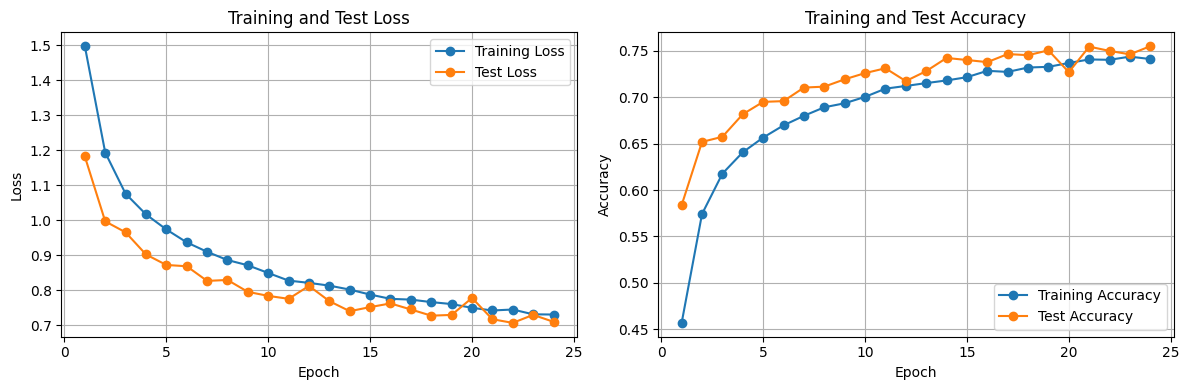

In [ ]:
# пример использования класса
trainer = ClassificationTrainer(model=simple_model,
                                train_loader=train_loader,
                                test_loader=test_loader,
                                batch_size=128,
                                learning_rate=0.001,
                                num_epochs=25,
                                update_frequency=10)
trainer.train()
trainer.plot_training_history()

Загрузим лучшие веса и проведем итоговое тестирование `SimpleCNN`

In [ ]:
# Загружаем предварительно подготовленые веса по ссылке
import requests
import urllib.request
from urllib.parse import urlencode
import shutil
import zipfile

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/KQgJEKcF-otAew'
name_file = 'cifar.zip'

final_url = base_url + urlencode({'public_key': public_key})
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

if response.status_code == 200:
    urllib.request.urlretrieve(download_url, name_file)
    print("File successfully downloaded.")
else:
    print("Failed to download the file. Please check the URL link and file access.")

current_directory = os.getcwd()

with zipfile.ZipFile(name_file, 'r') as zip_ref:
    zip_ref.extractall(current_directory)

print(f'Unzipped contents to {current_directory}')

File successfully downloaded.


In [ ]:
SimpleCNN_test = torch.load(trainer.path_model)

checkpoint = torch.load(trainer.path)
SimpleCNN_test.load_state_dict(checkpoint['model_state_dict'])
trainer.model = SimpleCNN_test

In [ ]:
losses, predicted_classes, true_classes = trainer.validate()
test_accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Accuracy: {test_accuracy:.4f}')

Loss: 0.8008; Accuracy: 0.7812: : 320it [00:01, 160.90it/s]                                                            

Accuracy: 0.7524


По итогу получили **Accuracy** 75.25%

#### ImprovedCNN

Краткое описание того, что делает данный класс `ImprovedCNN`:

1. **Инициализация нейронной сети**: В конструкторе класса определены слои и параметры нейронной сети, включая сверточные слои, слои нормализации и активации, а также полносвязанные слои. Каждый слой выполняет определенную операцию, такую как свертку, активацию ReLU и пулинг.

2. **Сверточные слои**: Сеть содержит три сверточных слоя (`conv1`, `conv2`, `conv3`), которые извлекают признаки из входных изображений. Каждый слой выполняет свертку с различным числом фильтров (32, 64 и 128 соответственно) и применяет активацию ReLU.

3. **Слои нормализации**: Для улучшения стабильности и скорости обучения сеть также включает слои батч-нормализации (`bn1`, `bn2`, `bn3`), которые нормализуют активации на каждом слое.

4. **Пулинг слои**: После каждого сверточного слоя используются пулинг слои (`pool1`, `pool2`, `pool3`), которые уменьшают размерность изображения и усредняют значения признаков.

5. **Полносвязанные слои**: После третьего сверточного слоя данные проходят через два полносвязанных слоя (`fc1` и `fc2`). Первый полносвязанный слой имеет 256 нейронов и применяет активацию ReLU. Второй полносвязанный слой имеет выходное количество нейронов, соответствующее количеству классов (заданному параметром `num_classes`), и представляет собой финальный слой для классификации.


In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
improve_model = ImprovedCNN(num_classes=10)
summary(improve_model, (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 32, 32, 32]             896
       BatchNorm2d-2           [32, 32, 32, 32]              64
              ReLU-3           [32, 32, 32, 32]               0
         MaxPool2d-4           [32, 32, 16, 16]               0
            Conv2d-5           [32, 64, 16, 16]          18,496
       BatchNorm2d-6           [32, 64, 16, 16]             128
              ReLU-7           [32, 64, 16, 16]               0
         MaxPool2d-8             [32, 64, 8, 8]               0
            Conv2d-9            [32, 128, 8, 8]          73,856
      BatchNorm2d-10            [32, 128, 8, 8]             256
             ReLU-11            [32, 128, 8, 8]               0
        MaxPool2d-12            [32, 128, 4, 4]               0
           Linear-13                  [32, 256]         524,544
             ReLU-14                  [

Имеем по итогу **620 810** обучаемых параметров

Обучение завершено!!!
Best accuracy: 0.8339


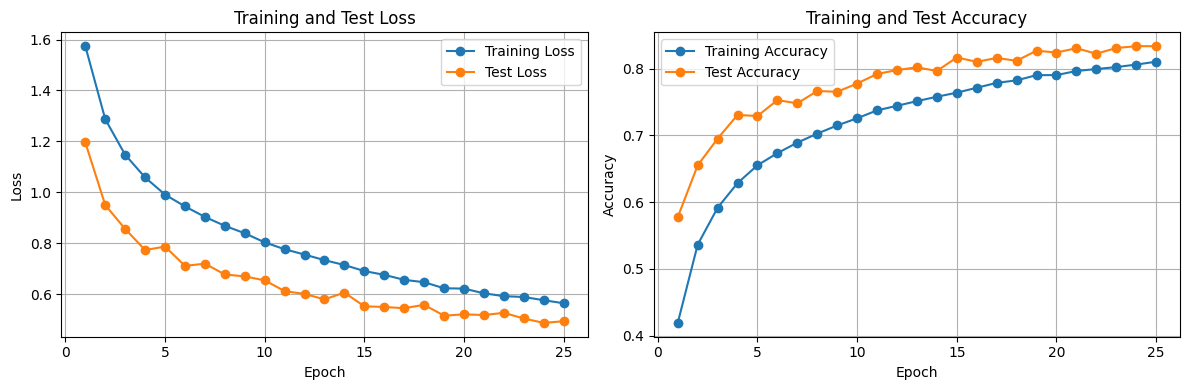

In [ ]:
trainer_improve = ClassificationTrainer(model=improve_model,
                                train_loader=train_loader,
                                test_loader=test_loader,
                                batch_size=128,
                                learning_rate=0.001,
                                num_epochs=25,
                                update_frequency=10)
trainer_improve.train()
trainer_improve.plot_training_history()

Загрузим лучшие веса и проведем итоговое тестирование `ImprovedCNN`

In [ ]:
ImprovedCNN_test = torch.load(trainer_improve.path_model)

checkpoint = torch.load(trainer_improve.path)
ImprovedCNN_test.load_state_dict(checkpoint['model_state_dict'])
trainer_improve.model = ImprovedCNN_test

In [ ]:
losses, predicted_classes, true_classes = trainer_improve.validate()
test_accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Accuracy: {test_accuracy:.4f}')

Loss: 0.4207; Accuracy: 0.8750: : 320it [00:02, 125.17it/s]                                                            

Accuracy: 0.8339


По итогу получили **Accuracy** 83.39%

#### ResNet

Класс `ResNet` представляет собой CNN, основанную на архитектуре ResNet (Residual Network), которая спроектирована для классификации изображений.
https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu2(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.res1 = ResBlock(128, 128)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.res2 = ResBlock(512, 512)

        self.classifier = nn.Sequential(
            nn.MaxPool2d(kernel_size=4),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
        self.initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x)
        return self.classifier(x)

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)

In [ ]:
resnet_model = ResNet(num_classes=10)
summary(resnet_model, (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,792
       BatchNorm2d-2           [32, 64, 32, 32]             128
              ReLU-3           [32, 64, 32, 32]               0
            Conv2d-4          [32, 128, 32, 32]          73,856
       BatchNorm2d-5          [32, 128, 32, 32]             256
              ReLU-6          [32, 128, 32, 32]               0
         MaxPool2d-7          [32, 128, 16, 16]               0
            Conv2d-8          [32, 128, 16, 16]         147,584
       BatchNorm2d-9          [32, 128, 16, 16]             256
             ReLU-10          [32, 128, 16, 16]               0
           Conv2d-11          [32, 128, 16, 16]         147,584
      BatchNorm2d-12          [32, 128, 16, 16]             256
             ReLU-13          [32, 128, 16, 16]               0
         ResBlock-14          [32, 128,

Имеем по итогу **6 575 370** обучаемых параметров

Обучение завершено!!!
Best accuracy: 0.9101


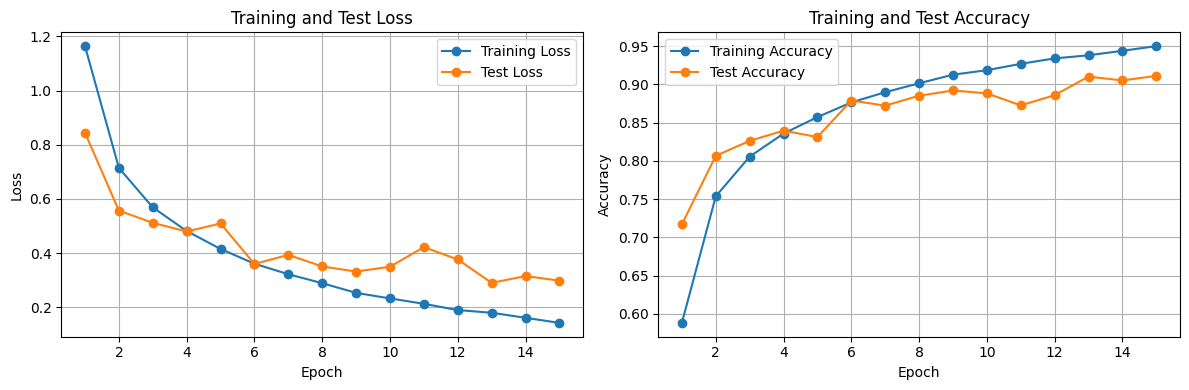

In [ ]:
trainer_resnet = ClassificationTrainer(model=resnet_model,
                                train_loader=train_loader,
                                test_loader=test_loader,
                                batch_size=128,
                                learning_rate=0.001,
                                num_epochs=15,
                                update_frequency=2)
trainer_resnet.train()
trainer_resnet.plot_training_history()

Загрузим лучшие веса и проведем итоговое тестирование `ResNet`

In [ ]:
ResNet_test = torch.load(trainer_resnet.path_model)

checkpoint = torch.load(trainer_resnet.path)
ResNet_test.load_state_dict(checkpoint['model_state_dict'])
trainer_resnet.model = ResNet_test

In [ ]:
losses, predicted_classes, true_classes = trainer_resnet.validate()
test_accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Accuracy: {test_accuracy:.4f}')

Loss: 0.3200; Accuracy: 0.9375: : 314it [00:13, 22.96it/s]                                                             

Accuracy: 0.9101


По итогу получили **Accuracy** 91.01%

**Итоговый вывод**:

В рамках данной практической работы была решена задача классификации изображений на датасете Cifar-10. Были созданы и обучены три различные модели: `SimpleCNN`, `ImprovedCNN` и `ResNet`.

- Модель `SimpleCNN` представляет собой простую сверточную нейронную сеть. Эта модель достигла точности на уровне 75.25%.

- Модель `ImprovedCNN` представляет собой более сложную сверточную сеть с дополнительными слоями и методами регуляризации. Это позволило ей достичь более высокой точности в 83.39%.

- Модель `ResNet` - это глубокая нейронная сеть с использованием блоков с пропусками (residual blocks), что позволяет эффективно обучать глубокие сети. Она достигла наилучшей производительности с точностью в 91.01%.

Также были применены различные методы предварительной обработки данных, включая нормализацию (Normalize), случайные обрезки (RandomCrop) и отражения по горизонтали (RandomHorizontalFlip), чтобы улучшить производительность моделей.